In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
from scipy import stats

## one dimensional

In [3]:
w_0 = 0

n_trials = 20
obs = np.ones(n_trials)
rew = np.concatenate((np.ones(n_trials//2), np.zeros(n_trials-n_trials//2)))
mem_w = []
sigma_o = 0.5

sigma_d = 0.1
sigma_j = 1

pi = 0.0075


In [4]:
n_samples = 50
mem_w = {}
mem_w_mean = np.zeros(n_trials)
for sample in range(n_samples):
    w = w_0
    jump = False
    mem_w[sample] = []
    for t in range(n_trials):
        # maj model
        if jump:
            w_tilde = np.random.normal(0, sigma_j)
        else:
            w_tilde = w + np.random.normal(0, sigma_d)
        x, r = obs[t], rew[t]
        r_tilde = w_tilde * x
        delta = r - r_tilde
        k = sigma_d**2 / (sigma_d**2 + sigma_o**2) # Kalman gain
        w = w_tilde + x * k * delta
        log_p_jump = np.log(pi) + np.log(stats.norm(0, sigma_j).pdf(r))
        log_p_no_jump = np.log(1-pi) + np.log(stats.norm(w*x, sigma_d).pdf(r))
        jump = log_p_jump > log_p_no_jump
        #print(f"jump : {log_p_jump}, no_jump : {log_p_no_jump}, JUMP={jump}")
        mem_w[sample] += [w]
    mem_w[sample] = np.array(mem_w[sample])
    mem_w_mean += mem_w[sample] / n_samples
    
    

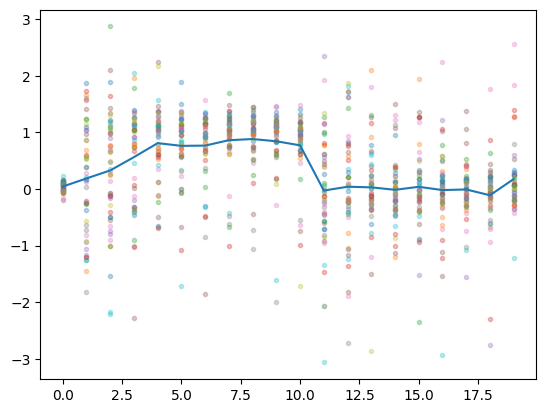

In [5]:
for sample in range(n_samples):
    plt.plot(range(n_trials), mem_w[sample], '.', alpha=.3)
plt.plot(mem_w_mean)

## two_dimensional

In [30]:
w_0 = np.zeros(2)

Sigma_d = [[0.01, -0.005],[-0.005, 0.01]]
#Sigma_d = [[0.01, 0],[0, 0.01]]
Sigma_j = [[1, 0],[0, 1]]

n_trials = 50
# AB+ | A-
obs = np.array([[1,1]] * (n_trials//2) + [[1,0]] * (n_trials-n_trials//2))
rew = np.concatenate((np.ones(n_trials//2), np.zeros(n_trials-n_trials//2)))
# AB+ | B+
#obs = np.array([[1,1]] * (n_trials//2) + [[0,1]] * (n_trials-n_trials//2))
#rew = np.ones(n_trials)
# A+ | AB+
# obs = np.array([[1,0]] * (n_trials//2) + [[1,1]] * (n_trials-n_trials//2))
# rew = np.ones(n_trials)

mem_w = []
sigma_j = 1
sigma_d = 0.1
sigma_o = 0.25

pi = 0.0075


In [35]:
n_samples = 50
mem_w = {}
mem_k = {}
mem_jump = {}

mem_w_mean = np.zeros((n_trials,2))
for sample in range(n_samples):
    w = w_0
    jump = False
    mem_w[sample] = []
    mem_k[sample] = []
    mem_jump[sample] = []
    for t in range(n_trials):
        # maj model
        w_tilde_jump = np.random.multivariate_normal((0, 0), Sigma_j)
        w_tilde_no_jump = w + np.random.multivariate_normal((0, 0), Sigma_d)
        x, r = obs[t], rew[t]
        log_p_jump = np.log(pi) + np.log(stats.norm(np.dot(w_tilde_jump, x), sigma_o).pdf(r))
        log_p_no_jump = np.log(1-pi) + np.log(stats.norm(np.dot(w_tilde_no_jump, x), sigma_o).pdf(r))
        jump = log_p_jump > log_p_no_jump
        if jump:
            # print(w_tilde_jump, w_tilde_no_jump, log_p_jump, log_p_no_jump, jump)
            w_tilde = w_tilde_jump
            mem_jump[sample] += [w_tilde]
            Sigma_ref = Sigma_j
        else:
            w_tilde = w_tilde_no_jump
            mem_jump[sample] += [np.nan * w_tilde]
            Sigma_ref = Sigma_d
        r_tilde = np.dot(w_tilde, x)
        delta = r - r_tilde
        k = np.dot(x, Sigma_ref) / (np.dot(x, np.dot(Sigma_ref, x.T))  + sigma_o**2) # Kalman gain
        
        w = w_tilde +  k * delta
        #k = sigma_d**2 / (sigma_d**2 + sigma_o**2) # Kalman gain
        #w = w_tilde +  x * k * delta
        
        #log_p_jump = np.log(pi) + np.log(sp.stats.norm(0, np.sqrt(sigma_j**2+sigma_o**2)).pdf(r))
        #log_p_no_jump = np.log(1-pi) + np.log(sp.stats.norm(np.dot(w,x), sigma_o).pdf(r))        
        
        #print(f"jump : {log_p_jump}, no_jump : {log_p_no_jump}, JUMP={jump}")
        mem_w[sample] += [w]
        mem_k[sample] += [k]
    mem_w[sample] = np.array(mem_w[sample])
    mem_w_mean += mem_w[sample] / n_samples
    
    

In [36]:
x = np.array([1,1])
np.dot(x, np.dot(Sigma_d, x.T))

0.01

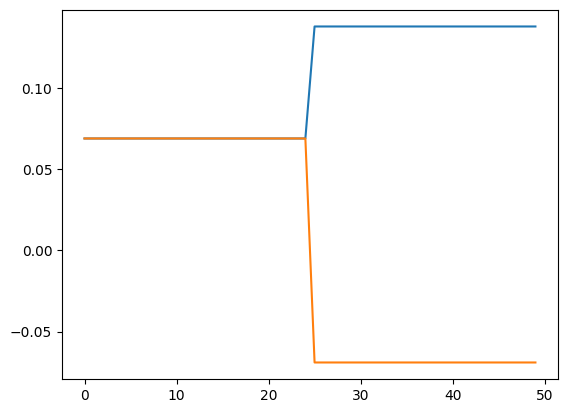

In [38]:
plt.plot(mem_k[1])

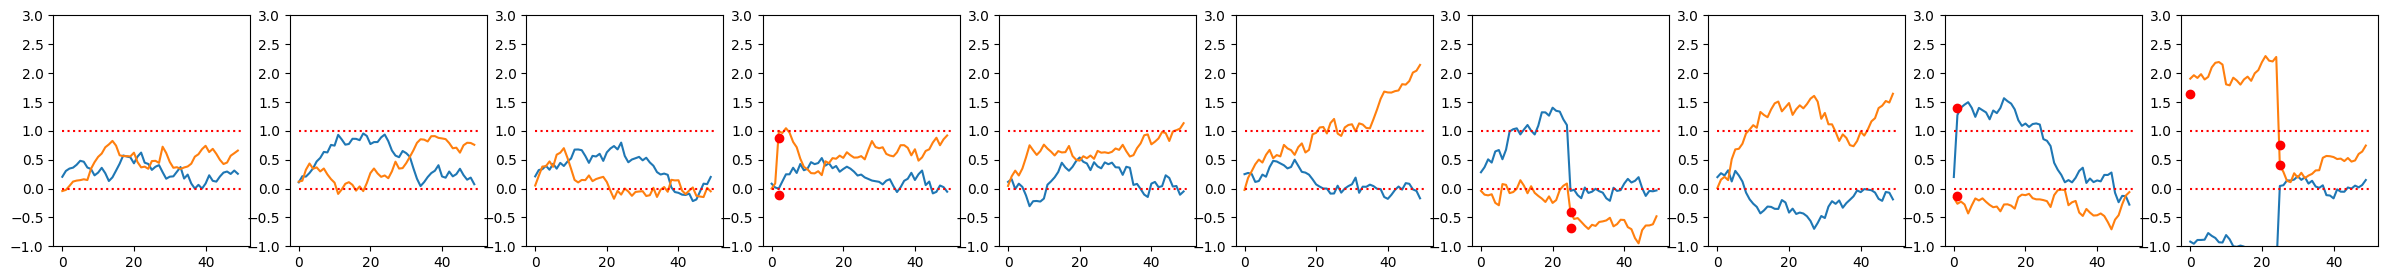

In [39]:
plt.figure(figsize=(30,3))
for sample in range(10):
    plt.subplot(1,10,1+sample)
    plt.plot(mem_w[sample])
    plt.plot(mem_jump[sample],'or')
    plt.ylim(-1,3)
    plt.plot([0,n_trials],[0,0],'r:')
    plt.plot([0,n_trials],[1,1],'r:')

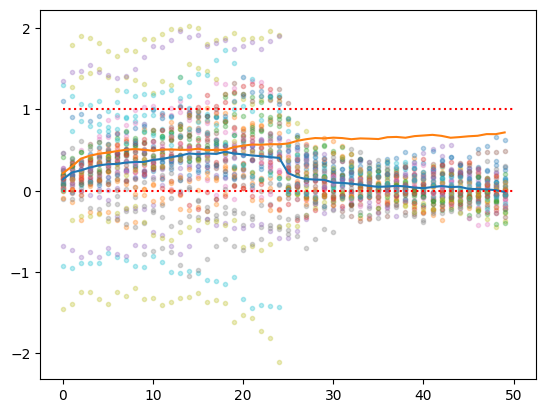

In [40]:
for sample in range(n_samples):
    plt.plot(range(n_trials), mem_w[sample][:,0], '.', alpha=.3)
plt.plot(mem_w_mean[:,0])
plt.plot(mem_w_mean[:,1])
plt.plot([0,n_trials],[0,0],'r:')
plt.plot([0,n_trials],[1,1],'r:')

(-1.5, 1.5)

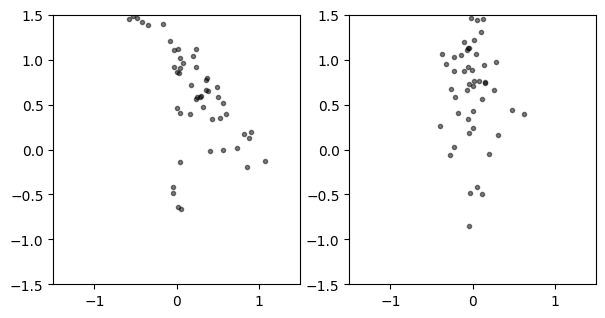

In [41]:
plt.figure(figsize=(7,3.5))
plt.subplot(1,2,1)
for sample in range(n_samples):
    plt.plot(mem_w[sample][n_trials//2,0], mem_w[sample][n_trials//2,1], '.k', alpha=.5)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

plt.subplot(1,2,2)
for sample in range(n_samples):
    plt.plot(mem_w[sample][n_trials-1,0], mem_w[sample][n_trials-1,1], '.k', alpha=.5)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)


array([[ 0.21598457, -0.10109491],
       [-0.10109491,  0.19700595]])

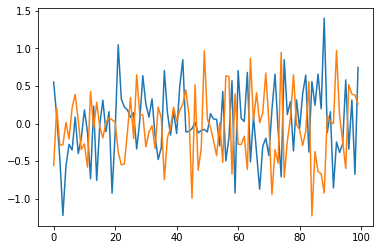

In [13]:
Sigma = [[0.2, -0.1],[-0.1, 0.2]]
test = np.random.multivariate_normal((0,0), Sigma,100)
plt.plot(test)
np.cov(test.T)

In [14]:
np.log(1-pi)

-0.0075282664207915245